In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *
import sklearn.tree as tree
import itertools
from itertools import product

# MGMTMSA 408 – Operations Analytics
# Homework 3 – Inventory Optimization and Traveling Salesman Problem
### Name: Joy Lin                                 
### UID: 806304435



# 1 Hospital Staffing
## Part 1: Formulating a basic newsvendor model
### a) As a warmup, suppose that on a given day, there are 12 ED cases, and we have staffed 18 regular nurses. What would be the staffing cost incurred by the hospital?

In [ ]:
18 * 2160

38880

### b) Now, suppose that there are 8 ED cases, and we have staffed 5 regular nurses. What would be the staffing cost incurred by the hospital in this case?

In [ ]:
5 * 2160 + (8-5) * 5400

27000

### c) Formulate the problem of deciding the daily regular nurse staffing level so as to minimize daily expected cost as a cost-based newsvendor problem. What does the “order quantity” Q correspond to? What does the “demand” D correspond to? What are the overage cost $c_o$ and underage cost $c_u$?

$ min E[ C_o(Q-D)^+ + C_u(D-Q)^+ ]$

- Q: number of regular nurses staffed on a day
- D: number of of ED cases on the day
- $c_o$: compensation for nurses assigned to handle ED cases when Q > D on the day
- $c_u$: compensation for agency nurses called in when D > Q on the day


### d) In part (d), the cost-based newsvendor problem you have formulated is missing one more “unavoidable” cost component. What is it? Express this cost using the random variable D. (Hint: suppose that there are 8 ED cases, and we have staffed 8 regular nurses. What does the total staffing cost end up being? What if there are 10 ED cases and 10 regular nurses?)

The compensation for regular nurses staffed but not assigned to handle ED cases when Q > D on the day.

2160 * D


## Part 2: Solving the basic newsvendor model

### For this part of the problem, we will use the data to determine a context-free nurse staffing level, i.e., a staffing level that does not incorporate the contextual information. Split the data into a training set and a test set, so that the training set consists of the first 200 days of data, and the test set consists of the last 100 days of data.

In [ ]:
nurse = pd.read_csv('nurse.csv')

nurse_train = nurse.iloc[:200]
nurse_test = nurse.iloc[200:]

### a) Based on the overage and underage costs from Part 1, what quantile (i.e., a probability between 0 and 1) of the empirical distribution of DailyED should the optimal staffing level correspond to?

In [ ]:
co = 2160
cu = 5400 - 2160

quantile = cu / (cu + co)
quantile

0.6

### b) Based on the empirical distribution of DailyED in the training set, determine the optimal staffing level. You may round your answer to the nearest integer, if necessary.

In [ ]:
opt_staffing_level = round(np.quantile(nurse_train['DailyED'], quantile))
opt_staffing_level

16

### c) Based on the training set, what is the average cost, where the average is taken over the 200 days in the training set, that this staffing level would incur? (Make sure your calculation accounts for the unavoidable cost component from Part 1 (d).)

In [ ]:
train_dailyED = np.asarray(nurse_train['DailyED'])

cost = []
Q = opt_staffing_level

for i in range(len(train_dailyED)):
    D = train_dailyED[i]
    cost_i = cu * max((D-Q),0) + co * max((Q-D),0) + co * D
    cost.append(cost_i)

np.mean(cost)

41256.0

### d) Based on the test set, what is the average cost, where the average is taken over the 100 days in the test set, that this staffing level would incur? (Make sure your cost accounts for the unavoidable cost component from Part 1 (d).)

In [ ]:
test_dailyED = np.asarray(nurse_test['DailyED'])

cost = []
Q = opt_staffing_level

for i in range(len(test_dailyED)):
    D = test_dailyED[i]
    cost_i = cu * max((D-Q),0) + co * max((Q-D),0) + co * D
    cost.append(cost_i)

np.mean(cost)

39528.0

## Part 3: Solving the contextual newsvendor model

### Using the same training and test set as Part 2, we will now develop a contextual newsvendor model. Using the training set, build a regression tree using the sklearn.tree.DecisionTreeRegressor function to predict DailyED. Be sure to omit the variable Day from your independent variables. Set the maximum depth parameter (max depth) of your tree to 2.

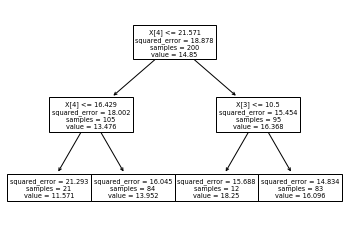

In [ ]:
X_train = nurse_train.drop(['DailyED', 'Day'], axis = 1)
y_train = nurse_train['DailyED']
X_test = nurse_test.drop(['DailyED', 'Day'], axis = 1)
y_test = nurse_test['DailyED']

nurse_tree = tree.DecisionTreeRegressor(max_depth = 2)
nurse_tree = nurse_tree.fit(X_train, y_train)

tree.plot_tree(nurse_tree)
plt.show()

### a) What variables does your tree split on?

In [ ]:
print(X_train.columns[4], ',', X_train.columns[3])

PriorSurgeries , DailyEDLag2


### b) For each leaf of the tree, calculate the optimal staffing level (rounded to the nearest integer) for the corresponding conditional distribution of DailyED given the training set. What is the optimal staffing level for each leaf of your tree?

In [ ]:
leaf_mapping = nurse_tree.apply(X_train)

leaves = [i for i in range(nurse_tree.tree_.node_count) if nurse_tree.tree_.children_left[i] == -1 ]

leaf_to_quantile = np.zeros(nurse_tree.tree_.node_count )

for ell in leaves:
    ind = (leaf_mapping == ell)
    y_ell = y_train[ind]
    leaf_to_quantile[ell] = round(np.quantile(y_ell, quantile))
    print("The optimal staffing level for leaf", ell, "is", round(np.quantile(y_ell, quantile)), '.')

The optimal staffing level for leaf 2 is 13 .
The optimal staffing level for leaf 3 is 15 .
The optimal staffing level for leaf 5 is 18 .
The optimal staffing level for leaf 6 is 17 .


### c) Based on the training set, what is the average cost, where the average is taken over the 200 days in the training set, that this staffing rule would incur? (Make sure your cost accounts for the unavoidable cost component from Part 1 (d).)

In [ ]:
staffing_levels = leaf_to_quantile[leaf_mapping]
train_dailyED = np.asarray(nurse_train['DailyED'])
cost = []

for i in range(len(train_dailyED)):
    cost_i = 0
    Q = staffing_levels[i]
    D = train_dailyED[i]
    cost_i = cu * max((D-Q),0) + co * max((Q-D),0) + co * D
    cost.append(cost_i)

np.mean(cost)

40554.0

### d) Based on the test set, what is the average cost, where the average is taken over the 100 days in the test set, that this staffing rule would incur? (Make sure your cost accounts for the unavoidable cost component from Part 1 (d).)

In [ ]:
leaf_mapping = nurse_tree.apply(X_test)
staffing_levels = leaf_to_quantile[leaf_mapping]

test_dailyED = np.asarray(nurse_test['DailyED'])
cost = []

for i in range(len(test_dailyED)):
    cost_i = 0
    Q = staffing_levels[i]
    D = test_dailyED[i]
    cost_i = cu * max((D-Q),0) + co * max((Q-D),0) + co * D
    cost.append(cost_i)

np.mean(cost)

38772.0

# 2 Cargo freight scheduling



## Part 1: Building our data

In [ ]:
cargo = pd.read_csv('cargo-city-locations.csv')

cargo['LAT'] = cargo['Latitude']/360 * 2 * np.pi
cargo['LON'] = cargo['Longitude']/360 * 2 * np.pi

In [ ]:
def distance_time(city_i, city_j):
    LAT_i = cargo.loc[cargo['City']==city_i].loc[:,'LAT'].values[0]
    LON_i = cargo.loc[cargo['City']==city_i].loc[:,'LON'].values[0]
    LAT_j = cargo.loc[cargo['City']==city_j].loc[:,'LAT'].values[0]
    LON_j = cargo.loc[cargo['City']==city_j].loc[:,'LON'].values[0]
    H_ij = (1-np.cos(LAT_i-LAT_j))/2 + np.cos(LAT_i)*np.cos(LAT_j)*((1-np.cos(LON_i-LON_j))/2)

    d_ij = 2 * 6378.137 * np.arcsin(np.sqrt(H_ij))
    t_ij = d_ij / 908

    return d_ij, t_ij

In [ ]:
# The travel time from Des Moines, IA to Baton Rouge, LA is 1.3857 hours, corresponding to a distance of 1258.226 kilometers
distance_time('Des Moines', 'Baton Rouge')

(1258.2261386316286, 1.3857116064224984)

In [ ]:
city_pairs = (list(product(cargo['City'],cargo['City'])))
distance_time_df = pd.DataFrame(city_pairs, columns=['city_i', 'city_j'])

distances = []
times = []
for index, row in distance_time_df.iterrows():
    distance, time = distance_time(row['city_i'], row['city_j'])
    distances.append(distance)
    times.append(time)

distance_time_df['distance'] = distances
distance_time_df['time'] = times

distance_time_df = distance_time_df[distance_time_df.iloc[:,2]>0].dropna()

distance_time_df

,city_i,city_j,distance,time
1,Montgomery,Juneau,4591.735528,5.056977
2,Montgomery,Phoenix,2407.512376,2.651445
3,Montgomery,Little Rock,614.754613,0.677043
4,Montgomery,Sacramento,3243.340917,3.571961
5,Montgomery,Denver,1865.471838,2.054484
...,...,...,...,...
4618,Portland,Charlotte,3681.087606,4.054061
4619,Portland,Seattle,235.360927,0.259208
4620,Portland,Washington,3781.614483,4.164774
4621,Portland,El Paso,2071.136208,2.280987


### a) Which two cities have the highest travel time?

In [ ]:
distance_time_df.iloc[np.argmax(distance_time_df['time'])]

city_i         Honolulu
city_j          Augusta
distance    8233.880502
time            9.06815
Name: 562, dtype: object

### b) Which two cities have the smallest travel time?

In [ ]:
distance_time_df.iloc[np.argmin(distance_time_df['distance'])]

city_i           Trenton
city_j      Philadelphia
distance       44.982011
time             0.04954
Name: 2026, dtype: object

### c) Which city has the smallest average travel time to all of the other cities? (Here, the average is taken over the other 67 cities.)

In [ ]:
distance_time_df.groupby(['city_i'])['time'].mean().sort_values().index[0]

'Springfield'

## Part 2: Finding a schedule

### a) Set your seed to 50. Randomly generate 100 sequences of the 68 cities, and calculate the total travel time required to visit the cities according to each sequence. What is the average of the total travel times of these 100 randomly generated sequences, in hours?

In [ ]:
np.random.seed(50)
import numpy as np

random_cargos = []
for i in range(100):
    nCities = 68
    temp = np.random.permutation(nCities)
    temp_cargo = cargo.reindex(temp)
    random_cargos.append(temp_cargo)

In [ ]:
random_times = []

for random_cargo in random_cargos:

    city_j_df = random_cargo.copy()
    first_row = city_j_df.iloc[[0]]
    city_j_df = city_j_df.drop(city_j_df.index[0])
    city_j_df = pd.concat([city_j_df, first_row])

    random_distance_time_df = pd.DataFrame({
                                'city_i': random_cargo['City'].values,
                                'city_j': city_j_df['City'].values
                            })

    distances = []
    times = []
    for index, row in random_distance_time_df.iterrows():
        distance, time = distance_time(row['city_i'], row['city_j'])
        times.append(time)

    random_distance_time_df['time'] = times

    random_distance_time_df = random_distance_time_df[random_distance_time_df.iloc[:,2]>0].dropna()
    random_time = np.sum(random_distance_time_df['time'])
    random_times.append(random_time)

mean_time = sum(random_times) / len(random_times)
mean_time

149.46321866597592

### b) Suppose that we design the sequence of cities using the following heuristic. Starting from Los Angeles, the next city in the schedule is the one that is closest to the current city in travel time and has not been visited yet. What is the total travel time of this sequence, in hours?

In [ ]:
city_pairs = (list(product(cargo['City'],cargo['City'])))
distance_time_df = pd.DataFrame(city_pairs, columns=['city_i', 'city_j'])

distances = []
times = []
for index, row in distance_time_df.iterrows():
    distance, time = distance_time(row['city_i'], row['city_j'])
    distances.append(distance)
    times.append(time)

distance_time_df['distance'] = distances
distance_time_df['time'] = times

distance_time_df = distance_time_df[distance_time_df.iloc[:,2]>0].dropna()

In [ ]:
unvisited = cargo[cargo['City'] != 'Los Angeles']
total_time = 0
current_city = 'Los Angeles'
visited = []

while not unvisited.empty:
    next_city_row = distance_time_df[(distance_time_df['city_i'] == current_city) & (distance_time_df['city_j'].isin(unvisited['City']))].sort_values(by='time').iloc[0]
    next_city = next_city_row['city_j']
    travel_time = next_city_row['time']

    visited.append(current_city)

    total_time += travel_time
    current_city = next_city
    unvisited = unvisited[unvisited['City'] != next_city]

total_time += distance_time_df[(distance_time_df['city_i'] == current_city) & (distance_time_df['city_j'] == 'Los Angeles')]['time'].values[0]

total_time

35.85170675498238

### c) Solve an optimization problem to find the order in which the cities should be visited, so as to minimize the total travel time. What is the total travel time of this sequence, in hours?

In [ ]:
def getSubtours(sequence):

    subtour_list = []
    unvisited = list(range(nCities)) #keeps track of locations unvisited

    while ( len(unvisited) > 0 ):
        node = unvisited.pop()

        subtour = []
        subtour.append(node)

        next_node = list(filter(lambda t: t[0] == node, sequence))[0][1]

        while (next_node in unvisited):
            subtour.append(next_node)
            unvisited.remove(next_node)
            next_node = list(filter(lambda t: t[0] == next_node, sequence))[0][1]

        subtour_list.append(subtour)

    return subtour_list

def eliminateSubtours(model, where):
    if (where == GRB.Callback.MIPSOL):
        x_val = model.cbGetSolution(x)
        sequence = [ (i,j) for (i,j) in origin_dest_zipped if x_val[i,j] > 0.5]
        subtour_list = getSubtours(sequence)
        if (len(subtour_list) > 1):
            for subtour in subtour_list:
                model.cbLazy( sum(x[i,j] for i in subtour for j in subtour if i != j) <= len(subtour) - 1)

In [ ]:
city_pairs = list(product(cargo['City'], cargo['City']))

city_i_index_list = []
city_j_index_list = []

for city_pair in city_pairs:
    if city_pair[0] != city_pair[1]:
        city_i_index = cities.index(city_pair[0])
        city_i_index_list.append(city_i_index)
        city_j_index = cities.index(city_pair[1])
        city_j_index_list.append(city_j_index)


In [ ]:
origin_dest_zipped = list(zip(city_i_index_list, city_j_index_list))
travel_time_dict = dict( zip(origin_dest_zipped, distance_time_df['time']) )

nCities = 68

def filter_fn(t):
    flag = t[0] < nCities and t[1] < nCities
    return flag

od_pairs = list(filter(filter_fn, travel_time_dict.keys()))

In [ ]:
from gurobipy import *

m = Model()

x = m.addVars(od_pairs, vtype = GRB.BINARY)

for i in range(nCities):
    m.addConstr( sum(x[i,j] for j in range(nCities) if j != i ) == 1)
    m.addConstr( sum(x[j,i] for j in range(nCities) if j != i ) == 1)

m.setObjective(sum( travel_time_dict[i,j] * x[i,j] for (i,j) in od_pairs ), GRB.MINIMIZE)

m.update()
m.params.LazyConstraints = 1

m.optimize(eliminateSubtours)

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 136 rows, 4556 columns and 9112 nonzeros
Model fingerprint: 0x559c42e5
Variable types: 0 continuous, 4556 integer (4556 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-02, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 136 rows, 4556 columns, 9112 nonzeros
Variable types: 0 continuous, 4556 integer (4556 binary)

Root relaxation: objective 2.729102e+01, 162 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   27.29102    0    -          -   27.29102      -   

In [ ]:
sequence = [ (i,j) for (i,j) in od_pairs if x[i,j].x > 0.5]
subtour_list = getSubtours(sequence)
complete_tour = subtour_list[0]
complete_tour.append( complete_tour[0] )
print("Complete tour: ", complete_tour)

print([cities[i] for i in complete_tour])

Complete tour:  [67, 46, 63, 1, 8, 61, 58, 4, 27, 51, 56, 2, 65, 30, 35, 57, 60, 42, 55, 53, 17, 23, 3, 24, 15, 26, 14, 12, 13, 16, 41, 10, 0, 9, 59, 39, 62, 31, 45, 64, 19, 7, 54, 29, 50, 6, 38, 20, 28, 18, 44, 33, 37, 47, 34, 66, 21, 52, 48, 22, 32, 40, 49, 5, 43, 25, 11, 36, 67]
['Portland', 'Olympia', 'Seattle', 'Juneau', 'Honolulu', 'San Francisco', 'San Jose', 'Sacramento', 'Carson City', 'Los Angeles', 'San Diego', 'Phoenix', 'El Paso', 'Santa Fe', 'Oklahoma City', 'Dallas', 'Fort Worth', 'Austin', 'San Antonio', 'Houston', 'Baton Rouge', 'Jackson', 'Little Rock', 'Jefferson City', 'Topeka', 'Lincoln', 'Des Moines', 'Springfield', 'Indianapolis', 'Frankfort', 'Nashville', 'Atlanta', 'Montgomery', 'Tallahassee', 'Jacksonville', 'Columbia', 'Charlotte', 'Raleigh', 'Richmond', 'Washington', 'Annapolis', 'Dover', 'Philadelphia', 'Trenton', 'New York City', 'Hartford', 'Providence', 'Boston', 'Concord', 'Augusta', 'Montpelier', 'Albany', 'Harrisburg', 'Charleston', 'Columbus', 'Detro

In [ ]:
print(m.objval, 'hours')

30.55362427595556 hours
